# NOREGRET: A Digit Classifier That Knows When to Say "I Don't Know"

Author : Muhammed Ashrah



Most digit classifiers will confidently assign a label — even when the input is noise, a letter, or something completely unfamiliar.

**NOREGRET** takes a smarter approach. It combines:
- A simple CNN trained on MNIST
- Class-wise Beta modeling for confidence estimation
- Prototype-based rejection using embedding distances

Instead of blindly predicting, it learns to refuse uncertain inputs using calibrated confidence and representation similarity.

This notebook walks through the training, embedding extraction, class prototype generation, and certainty analysis , all toward building a digit classifier that says **"I know what I don’t know."**


Loading the Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml


In [2]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, parser="auto")

In [3]:
X_train,X_test=X[:60000],X[60000:]
y_train, y_test = y[:60000], y[60000:]
len(X_train)


60000

In [4]:
X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255
y_train = np.array(y_train, dtype=np.int8)
y_test = np.array(y_test, dtype=np.int8)

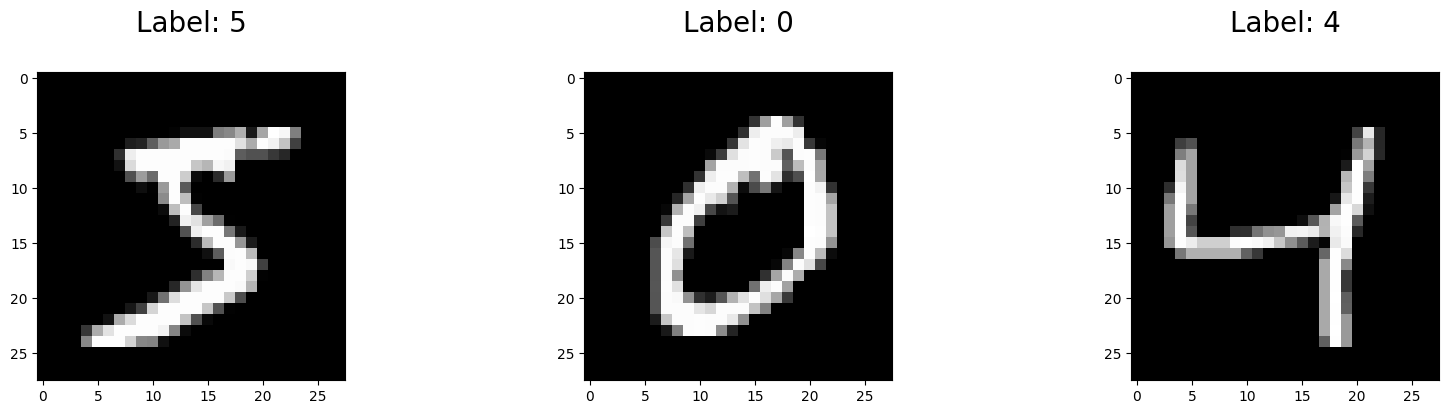

In [5]:
plt.figure(figsize=(20, 4))
for index, (image, label) in enumerate(zip(X_train[0:3], y_train[0:3])):
    plt.subplot(1, 3, index + 1)
    plt.imshow(np.reshape(image, (28, 28)), cmap=plt.cm.gray)
    plt.title("Label: %s\n" % label, fontsize=20)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)



BetaCal : Beta Calibration

In [14]:
# Default dict here allows us to initlize the keys of the dictionary to 1 by default . So we don’t need to manually check for existence.

from collections import defaultdict

alpha_count=defaultdict(lambda: 1)
beta_count=defaultdict(lambda:1)

for true, pred in zip(y_test, pred_labels):
    if pred == true:
        alpha_count[pred] += 1
    else:
        beta_count[pred] += 1



In [26]:
# Beta confidence captures both correctness and uncertainty, while accuracy only counts how often you're right

# For example , you could have 0.8 accuracy in 800 samples as well as in 10 samples but accuracy cannot differentiate , Hence we will go with Beta to make it easier to be explainability

from scipy.stats import beta

def beta_certainty(class_k):
    a = alpha_count[class_k]
    b = beta_count[class_k]
    mean = a / (a + b)
    var = (a * b) / ((a + b)**2 * (a + b + 1))
    entropy = beta.entropy(a, b)
    return mean, var, entropy


CNN - Model

In [16]:
from tensorflow.keras import layers, models, Input

inputs = Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)

embedding = layers.Dense(64, activation='relu')(x)  # We'll extract this for further usage .

outputs = layers.Dense(10, activation='softmax')(embedding)

model = models.Model(inputs=inputs, outputs=outputs)


In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.8690 - loss: 0.4356 - val_accuracy: 0.9813 - val_loss: 0.0627
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 43s 49ms/step - accuracy: 0.9826 - loss: 0.0568 - val_accuracy: 0.9870 - val_loss: 0.0449
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 87s 56ms/step - accuracy: 0.9872 - loss: 0.0393 - val_accuracy: 0.9912 - val_loss: 0.0372
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 74s 46ms/step - accuracy: 0.9912 - loss: 0.0291 - val_accuracy: 0.9882 - val_loss: 0.0424
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.9935 - loss: 0.0212 - val_accuracy: 0.9900 - val_loss: 0.0390


In [ ]:
# This here is returning the 64-dimensional feature vector of the layer before softmax
embedding_model = models.Model(inputs=model.input, outputs=embedding)


In [20]:
from tqdm import tqdm   # tqdm helps us to print a progress bar which helps us to know at what iteration the model has reached

# Embedding each training image individually is slow with O(n) complexity , and took about an hour on my machine.

# You could alternatively approach it through batching to reduce the time but however it may introduce noise due to BatchNorm statistics .Hence here we preferred to go simple with no batching.


prototypes = {k: [] for k in range(10)}

for xi, yi in tqdm(zip(X_train, y_train), total=len(X_train)):
    xi = xi.reshape(1, 28, 28, 1)
    emb = embedding_model.predict(xi, verbose=0)[0]
    prototypes[yi].append(emb)

for k in prototypes:
    prototypes[k] = np.mean(prototypes[k], axis=0)


100%|██████████| 60000/60000 [1:20:35<00:00, 12.41it/s]


In [21]:
from numpy.linalg import norm

def cosine_distance(u, v):
    return 1 - np.dot(u, v) / (norm(u) * norm(v))


In [22]:
preds = model.predict(X_test, verbose=0)
pred_labels = np.argmax(preds, axis=1)

for y_true, y_pred in zip(y_test, pred_labels):
    if y_pred == y_true:
        alpha_count[y_pred] += 1
    else:
        beta_count[y_pred] += 1


In [35]:
DIST_THRESHOLD = 0.15

from scipy.stats import beta

def predict_with_rejection(x):
    x = x.reshape(1, 28, 28, 1)
    probs = model.predict(x, verbose=0)
    pred = np.argmax(probs)

    emb = embedding_model.predict(x, verbose=0)[0]
    dist = cosine_distance(emb, prototypes[pred])

    mean, var, ent = beta_certainty(pred)

    print(f"Class: {pred} | Trust: {mean:.2f} | Var: {var:.4f} | Dist: {dist:.3f}")


    print(f"🌀 Entropy of Beta: {ent:.4f}")
    print(f"📏 Distance from Class {pred} Prototype: {dist:.3f}")

    if var > 0.01 or dist > DIST_THRESHOLD:
        reason = []
        if var > 0.01:
            reason.append("high uncertainty (Beta var)")
        if dist > DIST_THRESHOLD:
            reason.append("too far from prototype")
        print(f"⚠️ REJECTED: {' and '.join(reason)}")
    else:
        print("✅ ACCEPTED: Looks like a typical example of class", pred)


In [36]:
# Now to test for OOD we will use EMNITST Letters to check whether our rejection model is working

import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

ds = tfds.load('emnist/letters', split='test', as_supervised=True)

X_letters = []

for image, label in ds.take(10):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, -1)
    image = tf.image.transpose(image)
    X_letters.append(image.numpy())

for i, img in enumerate(X_letters):
    print(f"\nTesting EMNIST letter sample #{i}")
    predict_with_rejection(img)



Testing EMNIST letter sample #0
Class: 4 | Trust: 0.99 | Var: 0.0000 | Dist: 0.292
🌀 Entropy of Beta: -4.5815
📏 Distance from Class 4 Prototype: 0.292
⚠️ REJECTED: too far from prototype

Testing EMNIST letter sample #1
Class: 4 | Trust: 0.99 | Var: 0.0000 | Dist: 0.375
🌀 Entropy of Beta: -4.5815
📏 Distance from Class 4 Prototype: 0.375
⚠️ REJECTED: too far from prototype

Testing EMNIST letter sample #2
Class: 9 | Trust: 0.99 | Var: 0.0000 | Dist: 0.108
🌀 Entropy of Beta: -4.5995
📏 Distance from Class 9 Prototype: 0.108
✅ ACCEPTED: Looks like a typical example of class 9

Testing EMNIST letter sample #3
Class: 4 | Trust: 0.99 | Var: 0.0000 | Dist: 0.262
🌀 Entropy of Beta: -4.5815
📏 Distance from Class 4 Prototype: 0.262
⚠️ REJECTED: too far from prototype

Testing EMNIST letter sample #4
Class: 7 | Trust: 0.98 | Var: 0.0000 | Dist: 0.371
🌀 Entropy of Beta: -4.4735
📏 Distance from Class 7 Prototype: 0.371
⚠️ REJECTED: too far from prototype

Testing EMNIST letter sample #5
Class: 9 | 

In [37]:
import string
from collections import defaultdict

# Create a map: 0–25 → A–Z
letter_map = dict(zip(range(26), string.ascii_uppercase))

accepted = 0
rejected = 0
rejection_log = []  # for optional later plotting
confusion_map = defaultdict(int)

ds = tfds.load('emnist/letters', split='test', as_supervised=True)

for i, (image, label) in enumerate(ds.take(1000)):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, -1)
    image = tf.image.transpose(image)
    x_np = image.numpy()

    # True label (1–26) → subtract 1 to get 0–25 → map to A–Z
    true_letter = letter_map[int(label.numpy()) - 1]

    # Prediction
    x = x_np.reshape(1, 28, 28, 1)
    probs = model.predict(x, verbose=0)
    pred_digit = np.argmax(probs)

    emb = embedding_model.predict(x, verbose=0)[0]
    dist = cosine_distance(emb, prototypes[pred_digit])
    mean, var, _ = beta_certainty(pred_digit)

    # Accept/Reject decision
    if var > 0.01 or dist > DIST_THRESHOLD:
        rejected += 1
        decision = "REJECTED"
    else:
        accepted += 1
        decision = "ACCEPTED"

    # Log confusion
    confusion_map[(true_letter, pred_digit)] += 1

    # Optional: print first few
    if i < 10:
        print(f"[{i}] True: {true_letter} → Predicted Digit: {pred_digit} | Dist: {dist:.3f} | {decision}")

print("\n--- SUMMARY ---")
print(f"✅ Accepted: {accepted}")
print(f"❌ Rejected: {rejected}")
print(f"Rejection Rate: {rejected / (accepted + rejected):.2%}")


[0] True: M → Predicted Digit: 4 | Dist: 0.292 | REJECTED
[1] True: H → Predicted Digit: 4 | Dist: 0.375 | REJECTED
[2] True: A → Predicted Digit: 9 | Dist: 0.108 | ACCEPTED
[3] True: I → Predicted Digit: 4 | Dist: 0.262 | REJECTED
[4] True: F → Predicted Digit: 7 | Dist: 0.371 | REJECTED
[5] True: A → Predicted Digit: 9 | Dist: 0.243 | REJECTED
[6] True: L → Predicted Digit: 5 | Dist: 0.430 | REJECTED
[7] True: Q → Predicted Digit: 0 | Dist: 0.143 | ACCEPTED
[8] True: B → Predicted Digit: 9 | Dist: 0.314 | REJECTED
[9] True: H → Predicted Digit: 7 | Dist: 0.399 | REJECTED

--- SUMMARY ---
✅ Accepted: 170
❌ Rejected: 830
Rejection Rate: 83.00%


We manage to achieve an impressive **83 % on OOD**

Saving the model,alpha,beta and prototype

In [42]:
model.save("model.h5")

In [46]:
import numpy as np

np.save("prototypes.npy", prototypes)


In [48]:
import pickle

# Converting defaultdicts to regular dicts before pickling
alpha_dict = dict(alpha_count)
beta_dict = dict(beta_count)

with open("alpha_count.pkl", "wb") as f:
    pickle.dump(alpha_dict, f)

with open("beta_count.pkl", "wb") as f:
    pickle.dump(beta_dict, f)
